In [ ]:
%pip install missingno scipy

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Summary of Missing Values in the Dataset:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Dataset after Mean Imputation:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps      0
chol          0
fbs          90
restecg       2
thalch        0
exang        55
oldpeak       0
slope       309
ca            0
thal        486
num           0
dtype: int64

Dataset after Median Imputation:
id            0
age

C:\Users\Admin\AppData\Local\Temp\ipykernel_12700\1603250169.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mode_imputation[col] = df_mode_imputation[col].fillna(df_mode_imputation[col].mode()[0], inplace=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12700\1603250169.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12700\1603250169.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

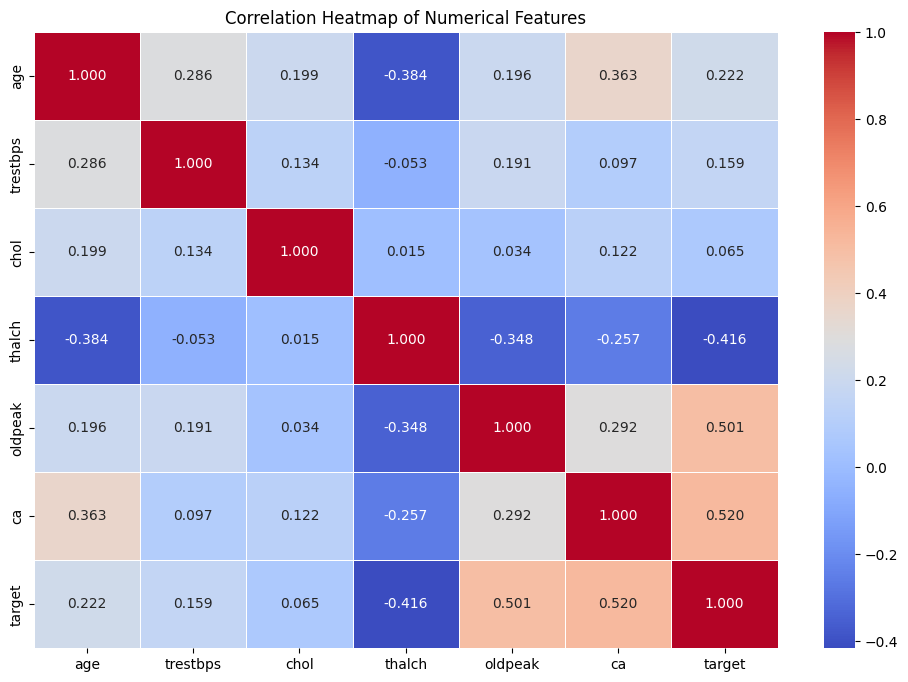


Selected Features based on Correlation Matrix (threshold > 0.1):
{'thalch', 'target', 'oldpeak', 'trestbps', 'chol', 'ca'}

Final Selected Features based on both Chi-Square and Correlation Matrix:
{'slope', 'thalch', 'target', 'ca', 'exang', 'sex', 'restecg', 'oldpeak', 'trestbps', 'chol', 'cp', 'fbs', 'thal'}

Dataset after Z-Score Outlier Removal: (290, 13)
Dataset after IQR Outlier Removal: (263, 13)

First 5 rows of Normalized Data:
[[0.708 0.481 0.287 0.603 0.371 0.   ]
 [0.792 0.623 0.401 0.282 0.242 1.   ]
 [0.792 0.245 0.278 0.443 0.419 0.667]
 [0.167 0.34  0.323 0.885 0.565 0.   ]
 [0.25  0.34  0.224 0.771 0.226 0.   ]]

First 5 rows of Standardized Data:
[[ 0.94   0.75  -0.263  0.029  1.069 -0.718]
 [ 1.384  1.596  0.748 -1.79   0.38   2.487]
 [ 1.384 -0.661 -0.339 -0.881  1.328  1.419]
 [-1.944 -0.097  0.061  1.632  2.103 -0.718]
 [-1.5   -0.097 -0.816  0.982  0.294 -0.718]]


In [26]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats

# Step 1: Load the heart disease dataset
df = pd.read_csv('heart_disease_uci.csv')

# Step 2: Display the first few rows and check for missing values
# print("Original Dataset:")
print(df.dtypes)

print("\nSummary of Missing Values in the Dataset:")
print(df.isnull().sum())

# Step 3: Handling missing data using different imputation methods

# Mean Imputation (for numeric columns)
df_mean_imputation = df.copy()
numeric_cols = df_mean_imputation.select_dtypes(include=['number']).columns
df_mean_imputation[numeric_cols] = df_mean_imputation[numeric_cols].fillna(df_mean_imputation[numeric_cols].mean(), inplace=False)

print("\nDataset after Mean Imputation:")
print(df_mean_imputation.isnull().sum())

# Median Imputation (for numeric columns)
df_median_imputation = df.copy()
df_median_imputation[numeric_cols] = df_median_imputation[numeric_cols].fillna(df_median_imputation[numeric_cols].median(), inplace=False)

print("\nDataset after Median Imputation:")
print(df_median_imputation.isnull().sum())

# Mode Imputation (for categorical columns)
df_mode_imputation = df.copy()
categorical_cols = df_mode_imputation.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_mode_imputation[col] = df_mode_imputation[col].fillna(df_mode_imputation[col].mode()[0], inplace=False)

print("\nDataset after Mode Imputation:")
print(df_mode_imputation.isnull().sum())

# Forward Fill (Fill missing values with the last known value)
df_ffill = df.copy()
df_ffill.fillna(method='ffill', inplace=True)

print("\nDataset after Forward Fill:")
print(df_ffill.isnull().sum())

# Backward Fill (Fill missing values with the next known value)
df_bfill = df.copy()
df_bfill.fillna(method='bfill', inplace=True)

print("\nDataset after Backward Fill:")
print(df_bfill.isnull().sum())

# Step 5: Dropping rows with missing data (if imputation isn't preferred)
df_dropped = df.copy()
df_dropped.dropna(inplace=True)

print("\nDataset after Dropping Rows with Missing Values:")
print(df_dropped.isnull().sum())

# Step 6: Define X (features) and y (target variable)
X = df_dropped.drop(columns=['num','dataset','id'])  # Replace 'num' with the actual target column
y = df_dropped['num']

# Label encode the categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_categorical = X[categorical_cols]

labelencoder = LabelEncoder()
X_categorical_encoded = X_categorical.apply(labelencoder.fit_transform)

# Step 7: Apply Chi-Square test to select top k features
chi2_selector = SelectKBest(chi2, k='all').fit(X_categorical_encoded, y)
chi2_scores = chi2_selector.scores_
chi2_features = chi2_selector.feature_names_in_.tolist()

# Get selected features from Chi-Square
selected_features_chi2_mask = chi2_selector.get_support()
selected_features_chi2 = X_categorical.columns[selected_features_chi2_mask]

print("Chi-Square Scores for Features:")
print(chi2_scores)
print("\nChi-Square Features:")
print(chi2_features)
print("\nSelected Features based on Chi-Square Test:")
print(selected_features_chi2)

# Step 8: Feature selection based on Correlation Matrix (for numerical features)
numeric_cols = X.select_dtypes(include=['number']).columns
corr_df = X[numeric_cols]
corr_df['target'] = y

# Calculate correlation matrix
correlation_matrix = corr_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Set a threshold for high correlation (e.g., absolute value > 0.75)
correlation_threshold = 0.1

# Find highly correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

print("\nSelected Features based on Correlation Matrix (threshold > 0.1):")
print(correlated_features)

# Step 9: Combine selected features from both Chi-Square and Correlation methods
selected_features_combined = set(selected_features_chi2).union(correlated_features)

print("\nFinal Selected Features based on both Chi-Square and Correlation Matrix:")
print(selected_features_combined)

# Step 10: Outlier Detection

# Detect outliers using Z-score on numeric data only
X_numeric = X.select_dtypes(include=[np.number])
z_scores = np.abs(stats.zscore(X_numeric))
X_zscore = X[(z_scores < 3).all(axis=1)]
y_zscore = y[(z_scores < 3).all(axis=1)]

print(f"\nDataset after Z-Score Outlier Removal: {X_zscore.shape}")

# Detect outliers using IQR
Q1 = X_numeric.quantile(0.25)
Q3 = X_numeric.quantile(0.75)
IQR = Q3 - Q1
X_iqr = X[~((X_numeric < (Q1 - 1.5 * IQR)) | (X_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
y_iqr = y[~((X_numeric < (Q1 - 1.5 * IQR)) | (X_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Dataset after IQR Outlier Removal: {X_iqr.shape}")

# Step 11: Feature Scaling

# Feature scaling (Normalization and Standardization)
scaler_norm = MinMaxScaler()
scaler_std = StandardScaler()

# Apply scaling to the numeric data
X_normalized = scaler_norm.fit_transform(X_numeric)
X_standardized = scaler_std.fit_transform(X_numeric)

# Display first 5 rows of normalized and standardized data
print("\nFirst 5 rows of Normalized Data:")
print(np.round(X_normalized[:5], 3))

print("\nFirst 5 rows of Standardized Data:")
print(np.round(X_standardized[:5], 3))


In [73]:
for i in X_numeric.columns:
    outliers_count = X[(X_numeric[i] < (Q1[i] - 1.5 * IQR[i])) | (X_numeric[i] > (Q3[i] + 1.5 * IQR[i]))][i].count()
    print(f"Column '{i}' has {outliers_count} outliers.")

Column 'age' has 0 outliers.
Column 'trestbps' has 9 outliers.
Column 'chol' has 6 outliers.
Column 'thalch' has 1 outliers.
Column 'oldpeak' has 5 outliers.
Column 'ca' has 20 outliers.
